In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, tree
from sklearn import externals
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import externals
from io import StringIO
from IPython.display import Image
from sklearn import tree 

import warnings
warnings.filterwarnings('ignore')

### 1 - Business Problem

### A cloth manufacturing company is interested to know about the segment or attributes causes high sale

### 2 - Data collection and description

In [3]:
companydata = pd.read_csv('Company_Data.csv')
companydata1 = companydata.copy()
companydata1

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [5]:
companydata1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,400.0,7.496325,2.824115,0.0,5.39,7.49,9.32,16.27
CompPrice,400.0,124.975000,15.334512,77.0,115.00,125.00,135.00,175.00
Income,400.0,68.657500,27.986037,21.0,42.75,69.00,91.00,120.00
Advertising,400.0,6.635000,6.650364,0.0,0.00,5.00,12.00,29.00
Population,400.0,264.840000,147.376436,10.0,139.00,272.00,398.50,509.00
Price,400.0,115.795000,23.676664,24.0,100.00,117.00,131.00,191.00
Age,400.0,53.322500,16.200297,25.0,39.75,54.50,66.00,80.00
Education,400.0,13.900000,2.620528,10.0,12.00,14.00,16.00,18.00


In [6]:
companydata1.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [7]:
companydata1.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

### Outlier Check

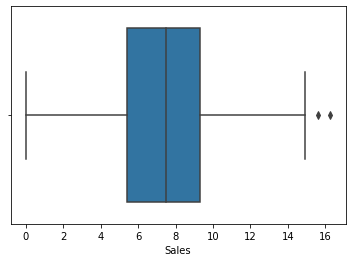

In [11]:
ax = sns.boxplot(companydata1['Sales']) # There are two outliers instances

Skew:0.18556036318721578
Kurtosis:-0.08087736743346197


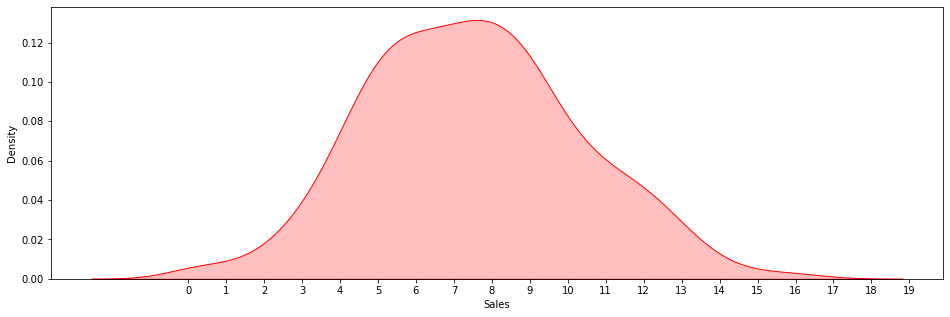

In [16]:
plt.rcParams["figure.figsize"]=9,5

plt.figure(figsize=(16,5))
print("Skew:{}".format(companydata1['Sales'].skew()))
print("Kurtosis:{}".format(companydata1['Sales'].kurtosis()))
ax=sns.kdeplot(companydata1['Sales'],shade=True,color='r')
plt.xticks([i for i in range(0,20,1)])
plt.show()

### The data is Skwed on the right
### The data has negative Kurtosis

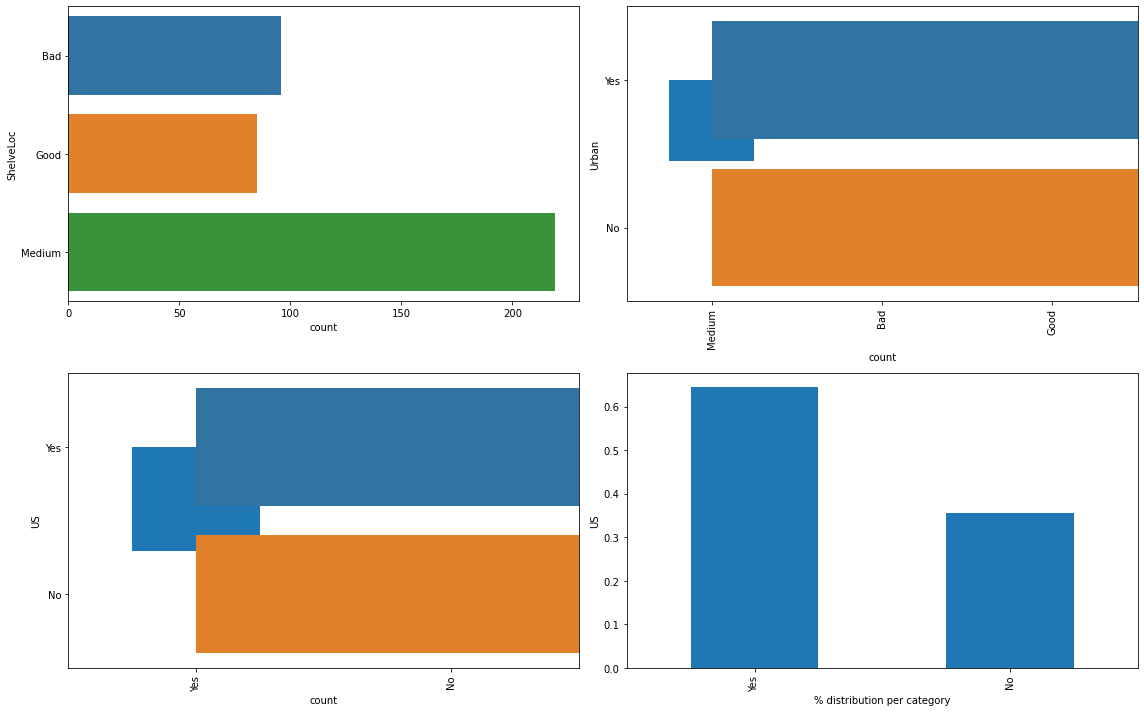

In [18]:
obj_colum = companydata1.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=companydata1,y=col)
    plt.subplot(2,2,i+1)
    companydata1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

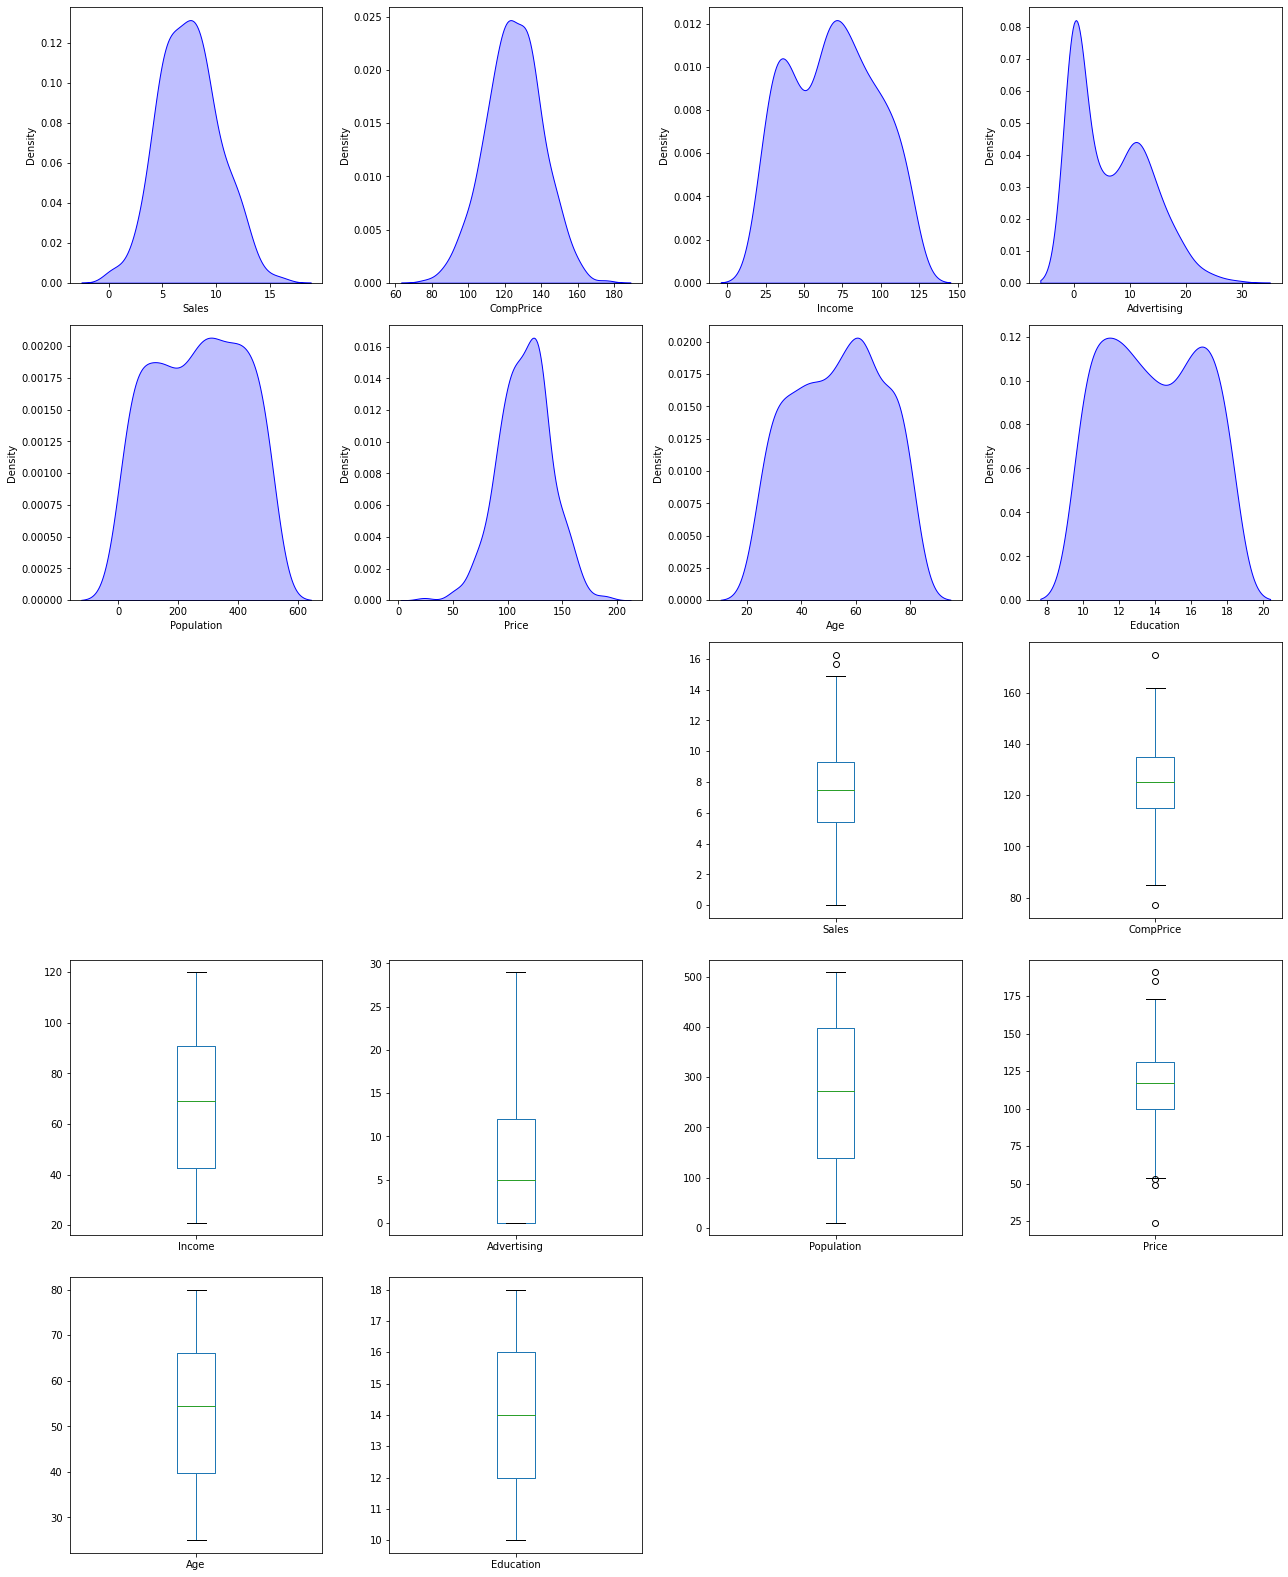

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
skewness,0.185560,-0.042755,0.049444,0.639586,-0.051227,-0.125286,-0.077182,0.044007
kurtosis,-0.080877,0.041666,-1.085289,-0.545118,-1.202318,0.451885,-1.134392,-1.298332


In [23]:
num_columns = companydata1.select_dtypes(exclude='object').columns.tolist()

plt.figure(figsize=(18,35))
for i,col in enumerate(num_colum,1):
    plt.subplot(8,4,i)
    sns.kdeplot(companydata1[col],color='b', shade = True)
    plt.subplot(8,4,i+10)
    companydata[col].plot.box()
plt.tight_layout()
plt.show()
num_data = companydata[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [24]:
corr=companydata1.corr()

In [25]:
companydata1=pd.get_dummies(companydata1, columns = ['ShelveLoc','Urban','US'])

In [26]:
corr=companydata1.corr()

<AxesSubplot:>

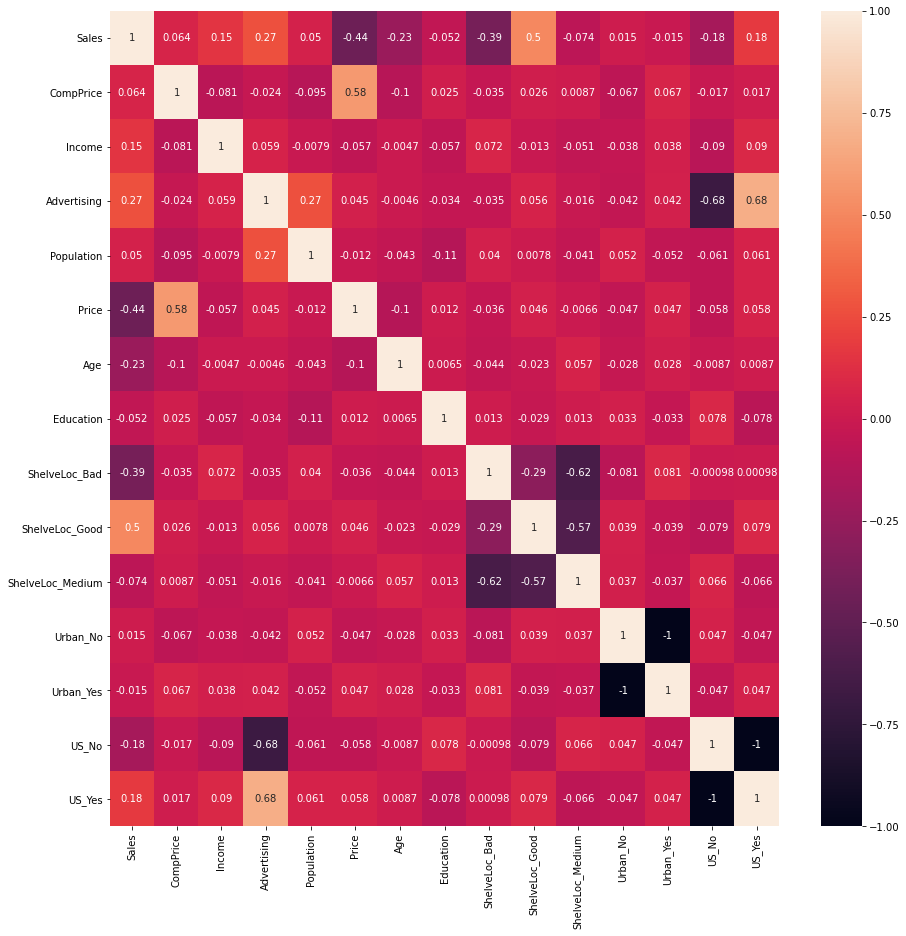

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True)

### 3 - Random Forest Model
#### Since the target variable is continious, we create a class of the value based on the mean
#### <= 7.49 == "Small" and > 7.49 == "large"

In [29]:
companydata1["sales"]="small"
companydata1.loc[companydata1["Sales"]>7.49,"sales"]="large"
companydata1.drop(["Sales"],axis=1,inplace=True)

In [31]:
X = companydata1.iloc[:,0:14]
y = companydata1.iloc[:,14]

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify = y)

In [37]:
y_train.value_counts()

small    161
large    159
Name: sales, dtype: int64

In [38]:
model=RF(n_jobs=4,n_estimators=150,oob_score=True,criterion='entropy')
model.fit(X_train,y_train)
model.oob_score_

0.79375

In [ ]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

In [39]:
pred_train = model.predict(X_train)
print('Accuracy Score:',accuracy_score(y_train,pred_train))
print('Confusion Matrix:\n',confusion_matrix(y_train,pred_train))

Accuracy Score: 1.0
Confusion Matrix:
 [[159   0]
 [  0 161]]


In [40]:
pred_test = model.predict(X_test)
print('Accuracy Score:',accuracy_score(y_test,pred_test))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred_test))

Accuracy Score: 0.775
Confusion Matrix:
 [[31  9]
 [ 9 31]]


In [42]:
cd = pd.DataFrame({'Actual': y_test, 'Predicted':pred_test})
cd

,Actual,Predicted
87,large,large
313,large,large
147,large,large
354,small,small
211,large,large
...,...,...
55,small,small
304,large,large
66,large,large
0,large,small


In [57]:
cols = list(companydata1.columns)

In [66]:
predictors = cols[0:14]
target = cols[14]

In [67]:
tree1 = model.estimators_[20]

In [68]:
dot_data = StringIO()

In [70]:
export_graphviz(tree1,out_file = dot_data,feature_names=predictors,class_names=target,filled=True,rounded=True,impurity=False,precision=2)

In [71]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [72]:
graph.write_png('company_full.png')

InvocationException: GraphViz's executables not found

### 4 - Conclusion
### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 77%
### As seen in the confusion matrix of Test data 62 instances are presdected correctly and 18 instances are not

In [78]:
rf_small = RF(n_estimators=10, max_depth=3)

In [79]:
rf_small.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [81]:
tree_small = rf_small.estimators_[5]

In [82]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [83]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [84]:
graph.write_png('company_small.png')

InvocationException: GraphViz's executables not found

In [85]:
img = mpimg.imread('company_small.png')

SyntaxError: not a PNG file (<string>)

In [86]:
plt.imshow(img)

NameError: name 'img' is not defined

In [87]:
model.feature_importances_

array([0.11120923, 0.10263517, 0.08531902, 0.0907134 , 0.2221749 ,
       0.11215023, 0.06370421, 0.05941129, 0.0759933 , 0.0283243 ,
       0.01322995, 0.01176633, 0.01098767, 0.012381  ])

In [90]:
cd1 = pd.DataFrame({'Feature': list(X_train.columns),
                   'Importance': model.feature_importances_}).\
                    sort_values('Importance', ascending = False)
cd1 # As seen in the table Price is most important feature

,Feature,Importance
4,Price,0.222175
5,Age,0.112150
0,CompPrice,0.111209
1,Income,0.102635
3,Population,0.090713
2,Advertising,0.085319
8,ShelveLoc_Good,0.075993
6,Education,0.063704
7,ShelveLoc_Bad,0.059411
9,ShelveLoc_Medium,0.028324
